In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load data and shift 2008 investment values into same row as 2007 controls

In [2]:
ccm_path = "output/ccm_with_risk.dta"
ccm = pd.read_stata(ccm_path)

# we want to compare 2007 risks with 2008 investment, so 
# we are going to create next_year_xrd which = 2008 r&d for 2007 obs
# and next_year_xrd is NaN in 2008 observations

ccm = ccm.sort_values(['gvkey','fyear']) 
ccm['next_rd'] = ccm.groupby('gvkey')['xrd_a'].shift(-1) 
ccm['next_capx'] = ccm.groupby('gvkey')['capx_a'].shift(-1) 

# IMPORTANT: the groupby ensures we never drag a value from one firm to another firm
# proof:    
print(ccm[['gvkey','fyear','xrd_a','next_rd','capx_a','next_capx']][:10])    

    gvkey   fyear     xrd_a   next_rd    capx_a  next_capx
0  1410.0  2007.0  0.000000  0.000000  0.021693   0.030395
1  1410.0  2008.0  0.000000       NaN  0.030395        NaN
2  1634.0  2007.0  0.000000  0.000000  0.013374   0.016993
3  1634.0  2008.0  0.000000       NaN  0.016993        NaN
4  1878.0  2007.0  0.219702  0.237989  0.024089   0.035493
5  1878.0  2008.0  0.237989       NaN  0.035493        NaN
6  1891.0  2007.0  0.018241  0.022158  0.006286   0.006792
7  1891.0  2008.0  0.022158       NaN  0.006792        NaN
8  2504.0  2007.0  0.043267  0.045678  0.019193   0.018588
9  2504.0  2008.0  0.045678       NaN  0.018588        NaN


## Defining the risk measures

Each of the risk measures is created by counting the number of times a topic is mentioned in a 10-K. In a naive approach, a topic is considered "mentioned" if a word related to that topic is used. However, this leads to excessive false positives. As such, I use an augmented approach wherein I search for multiple nearby terms. 

These measures are created in the `measure_risk.ipynb` file, using the `NEAR_regex` function to define the regex search patterns, but I copy the definitions here for ease of reference.

### Tax risk exposure

Technology firms are often involved in large amounts of creative accounting to reduce tax bills. To identify when a firm is negatively exposed to possible tax changes, I look for a firm mentioning a "risk term" near "tax" (or similar) and "changes". 

**HIT:** "A change to tax policies could negatively affect profits"

**NOT A HIT:** "A change to tax policies is likely"

```python
# this will look for mentions with 25 word gaps maximum
tax_risks = ['(risk|risks|could harm|negative|negatively|uncertain)',
            '(tax|taxes|taxation)',
            '(change|new|law|policy|policies|regulation|regulations)']
```

### Tariffs

Technology firms often ship product across international borders. To identify when a firm is negatively exposed to possible tariff changes, I look for a firm mentioning a "risk term" near "tariff" (or similar) and "changes". 

**HIT:** "A change to tariff policies could negatively affect profits"

**NOT A HIT:** "A change to tariff policies is likely"

```python
# this will look for mentions with 25 word gaps maximum
tariff_search = ['(risk|risks|could harm|negative|negatively)',
                '(tariff|tariffs)',
                '(change|new|law|policy|policies|regulation|regulations)']
```

### Financial constraints

Technology firms tend to be younger and smaller than other public firms. According to published research, young and small firms also tend to be financially constrained.

Following [Hoberg and Maksimovic](https://poseidon01.ssrn.com/delivery.php?ID=875082005085007108066003027097109092018052053087053016092066101124083072025114105026038106063111031098097099020098001110068066029018023080043026109080070118114124088008042110092095070091123122124087109120115122022004003119096075106076087081087092093&EXT=pdf), I define firms as financially constrained if a firm discusses "curtailing" near "investment". The full lists, below, come from the paper.

```python
# this list comes from page 9 of the WP version of Hoberg and Maksimovic (link above)

# allow for partial matches and a max gap of 25 (they use 12, but our text is messier)
fin_constraints = ['(delay|abandon|eliminate|curtail|scale back|postpone)',
                   '(construction|expansion|acquisition|restructuring|project|research|development|exploration|product|expenditure|manufactur|entry|renovat|growth|activities|capital improvement|capital spend|capital proj|commercial release|business plan|transmitter deployment|opening restaurants)' ]
```

### Proprietary Information Leak Risk

A crucial task for technology firms is protecting their IP. Following [Hoberg and Maksimovic](https://poseidon01.ssrn.com/delivery.php?ID=875082005085007108066003027097109092018052053087053016092066101124083072025114105026038106063111031098097099020098001110068066029018023080043026109080070118114124088008042110092095070091123122124087109120115122022004003119096075106076087081087092093&EXT=pdf) again, I define firms worried about IP leaks as those that discuss "protecting" near "trade secrets" or "proprietary information". I could use a larger list, but this definition has been vetted.

```python
proprietary_information_risks = ['(protect|safeguard)',
                                '(trade secret|proprietary  information|confidential  information)']
```

## Risk measure statistics

Below, I report summary statistics, which show meaningful variation across firms for each variable. Highlights:
- Tariff risk discussions are most rare, occurring in less than 25% of firm filings
- Financial constraints are most frequently discussed of these risks, with the max count being 26 within the sample.
- Less than 50% of firms discuss tax risk or proprietary information 

In [3]:
# describe the 2007 observations
(ccm
     .query('fyear==2007')
     [['next_rd','next_capx','l_stock_grant_citew','l_stock_trans_in_citew',
     'tax_risks','tariff_risk','fincon','proprietary']]     
     .describe()
     .round(2) # formatting
)

,next_rd,next_capx,l_stock_grant_citew,l_stock_trans_in_citew,tax_risks,tariff_risk,fincon,proprietary
count,169.00,169.00,169.00,161.00,148.00,148.00,148.00,148.00
mean,0.11,0.03,3.29,2.85,0.93,0.07,6.96,2.11
std,0.11,0.03,2.39,2.12,1.18,0.26,6.55,1.91
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.03,0.01,1.16,1.04,0.00,0.00,1.75,0.00
50%,0.09,0.02,3.21,2.87,1.00,0.00,5.00,2.00
75%,0.15,0.03,4.70,4.34,2.00,0.00,10.25,3.00
max,0.63,0.28,12.59,8.29,5.00,1.00,26.00,8.00


## Correlations and exploratory data analysis

Below I plot the correlations. 

R&D is, unsurprisingly, negatively correlated with CAPX and tax risks but positively correlated with prior year patent creation (`l_stock_grant_citew`) and patent acquisitions (`l_stock_trans_in_citew`), and tariff risks

It might seem surprising that R&D is positively correlated with financial constraints, but this is likely because tech firms (high R&D firms) tend to be young and small. As it turns out, young and small firms tend to be positively correlated. Controlling for age and size might in a regression might yield a negative coefficient.

Conversely, the correlations with CAPX are as expected: negatively related to patenting (opposite relation of R&D) and each risk proxy. 

Notably, these are not regressions, so each is pairwise without controls and the correlations below are just magnitudes without t-stats. 

Text(0.5, 1, 'Correlation Heatmap')

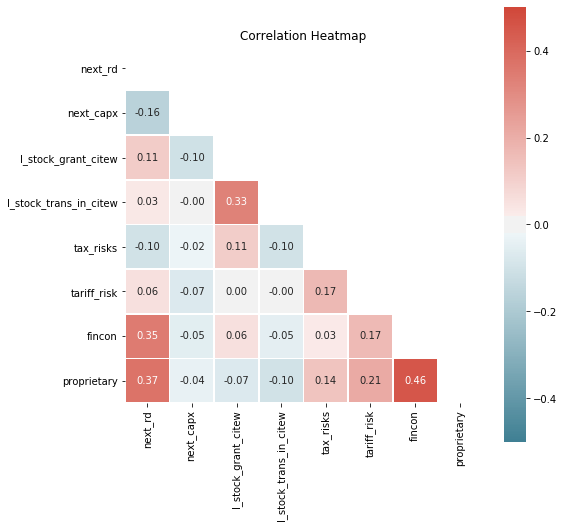

In [4]:
# get the correlations
corr = ccm[['next_rd','next_capx','l_stock_grant_citew','l_stock_trans_in_citew',
     'tax_risks','tariff_risk','fincon','proprietary']].corr()

# in the heatmap, we want to 
f, ax = plt.subplots(figsize=(8, 8))                    # control the size 
mask = np.triu(np.ones_like(corr, dtype=np.bool))       # hide the upper diag (redundant) 
cmap = sns.diverging_palette(220, 15, as_cmap=True, 
                             center='light')            # sets up color palette

# plot
sns.heatmap(corr, mask=mask, cmap=cmap,                 
            linewidths=.5, square=True,                 # linew
            vmax = .5, vmin = -.5, center=0,            # ensure palette shifts color at 0
            annot=True, fmt='.2f'                       # add the values
            ).set_title('Correlation Heatmap')


In [5]:
from statsmodels.formula.api import ols

fit = ols('next_rd ~ mb + age + l_a + cash_a + l_stock_grant_citew + fincon', data=ccm).fit() # C(Sex_male) + C(Job)
    # how I would improve this model:
    # 1. year FE:    add "C(year)" to model   ... except this is only one year of data
    #
    # 2. age and the risk measures are count variables (from 0 to some integer). often, it
    #    makes sense to log transform these variables, for example:
    #        ccm['l_age'] = np.log(1+ccm['age']) 
    #
    # 3. if we had 5+ years for every firm, include firm FE "C(gvkey)"
    #    --> this dramatically changes what the coefficients "mean". see future lectures for deets
    #
    # 4. data: look for outliers - does anything need to get winsorized or observations dropped
    #    
    # 5. data: more firms and more years of data would be nice!
    #
    # 6. PROBLEM: WHAT IS A "BIG" OR "IMPORTANT" MAGNTIDUDE COEFFICIENT?
    #
    #    Notice that for some X variables, an increase of 1 unit is "easy" and "common" while 
    #    for other X variables, an increase of 1 unit is almost impossible!
    #
    #    E.g.: age (common) and cash_a (impossible)
    #
    #    SOLUTION: divide all the coefficients by the standard deviation of that variable.
    #    Then, the interpretation of the coef changes from "for a 1 unit increase in X..."
    #    which, again, can be common or unlikely depending on the X 
    #    to "for a 1 Std Dev increase in X", and all var experience a 1 std dev increase 

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                next_rd   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     9.616
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           7.36e-09
Time:                        11:39:38   Log-Likelihood:                 139.03
No. Observations:                 148   AIC:                            -264.1
Df Residuals:                     141   BIC:                            -243.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0892      0.042      2.108      0.037       0.006       0.173
mb                      0.0171      0.006      2.674      0.008       0.004       0.030
age                    -0.0015      0.001     -1.330      0.186      -0.004       0.001
l_a                    -0.0160      0.006     -2.888      0.004      -0.027      -0.005
cash_a                  0.0309      0.042      0.733      0.465      -0.052       0.114
l_stock_grant_citew     0.0143      0.004      3.532      0.001       0.006       0.022
fincon                  0.0048      0.001      3.768      0.000       0.002       0.007
==============================================================================
Omnibus:                       70.165   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.641
Skew:                           1.849   Prob(JB):                     2.49e-52
Kurtosis:                       7.985   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""